In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *

In [3]:
path = Path('data/anime-faces')

In [4]:
data = ImageDataBunch.from_folder(path, 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=False, max_warp=0),
                                  size=64,bs=64, 
                                  num_workers=0).normalize() #not using a pretrained model

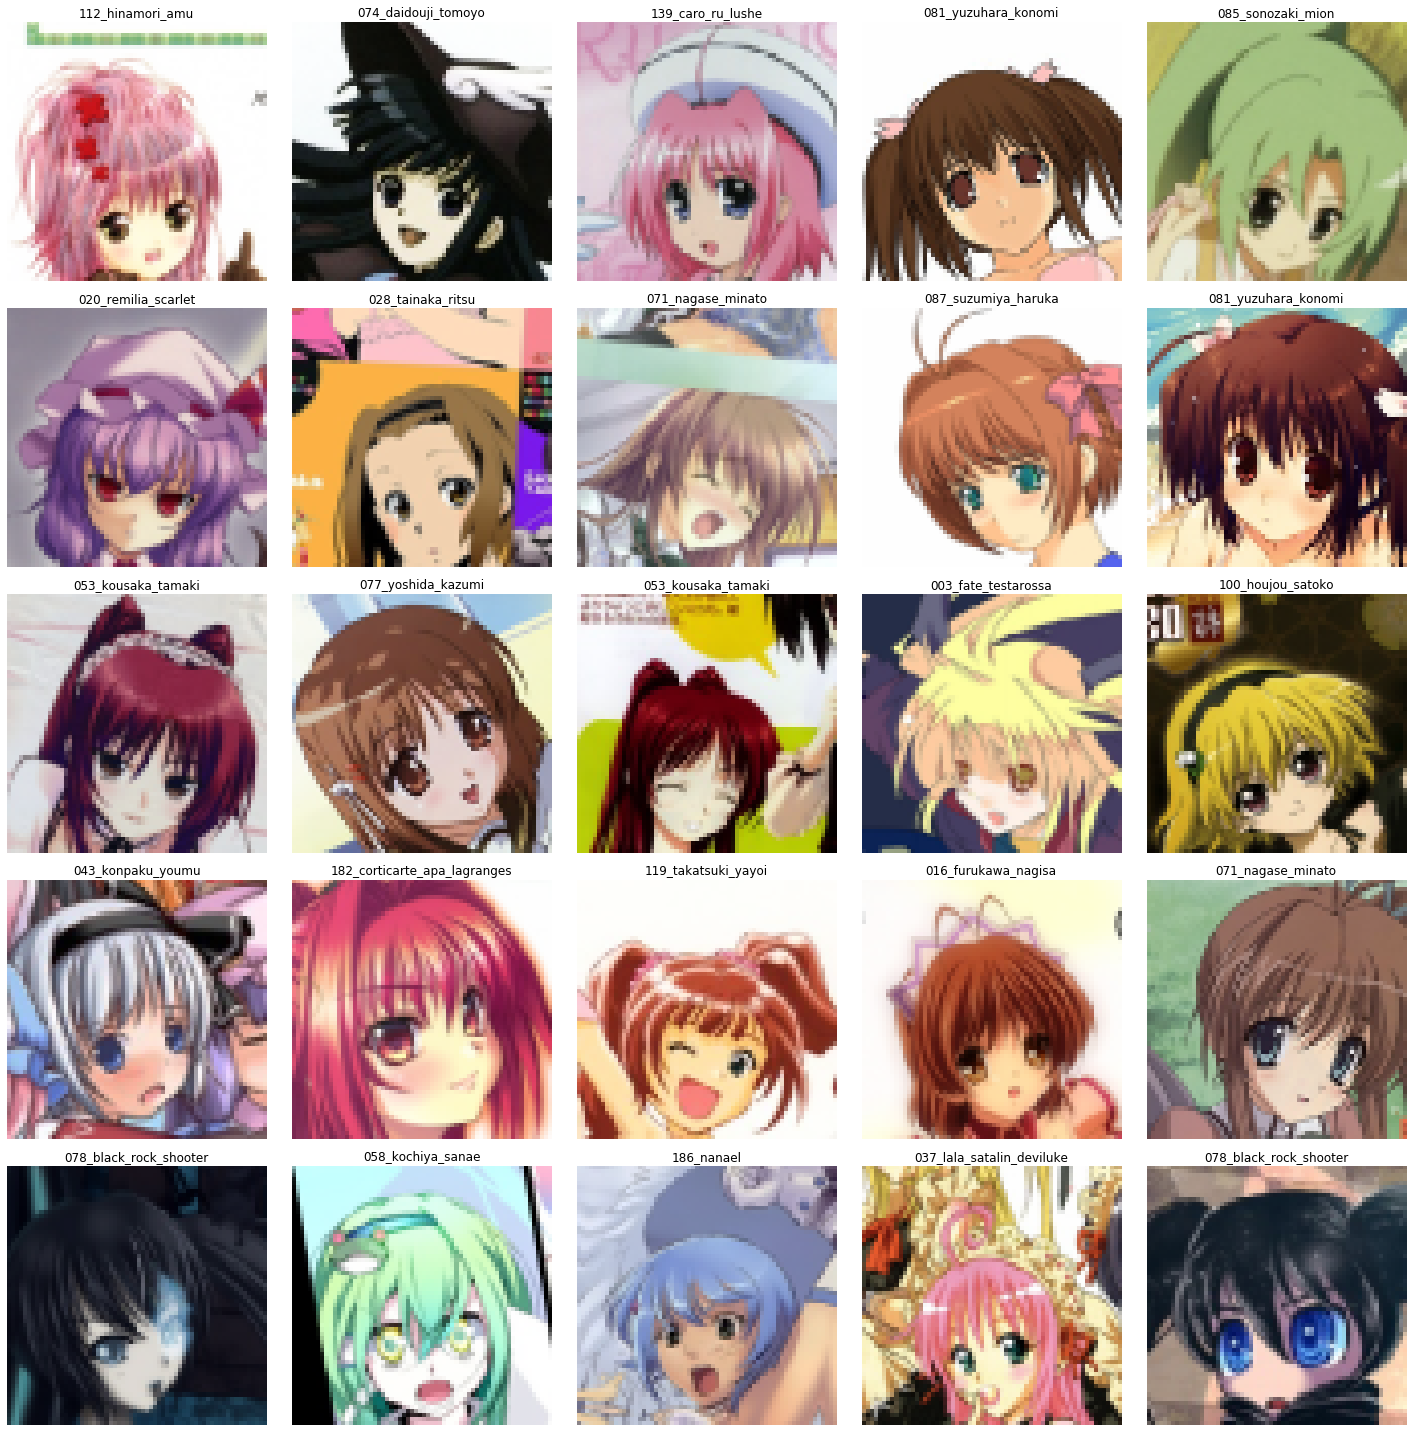

In [5]:
data.show_batch()

# using Pretrained Model

In [8]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [9]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,4.641892,3.916602,0.246961,02:05
1,2.418084,1.633818,0.605071,02:04
2,1.737191,1.034610,0.734977,02:01
3,1.428887,0.813125,0.778743,02:03
4,1.298917,0.677692,0.820771,02:03
5,1.135860,0.589534,0.837444,02:08
6,0.969979,0.548044,0.853421,02:06
7,0.891593,0.504242,0.868357,02:02
8,0.770763,0.481997,0.874957,02:04
9,0.744753,0.485208,0.867315,02:02


In [8]:
learn = cnn_learner(data, models.vgg16_bn, metrics=accuracy)

In [9]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 256, 256]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________________
Conv2d               [64, 256, 256]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________________
MaxPool2d            [64, 128, 128]       0          False     
___________________________________________________

In [10]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,4.223571,3.556795,0.300452,05:09
1,2.289113,1.410952,0.656131,05:06
2,1.742087,0.914065,0.755818,05:08
3,1.522938,0.716210,0.811046,05:05
4,1.264633,0.587904,0.844390,05:07
5,1.163022,0.514502,0.856200,05:09
6,0.963031,0.446732,0.881903,05:04
7,0.892788,0.404104,0.894755,05:18
8,0.798771,0.392077,0.899965,05:14
9,0.747406,0.389999,0.893366,05:07


# Simple CNN with Batch norm

In [6]:
def conv(ni,nf,ks=3,stride=2): return nn.Conv2d(ni,nf,kernel_size=ks, stride=stride, padding=1)

In [8]:
model =nn.Sequential(
    conv(3,8), #gridsiz 64
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16), #32
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32), #16
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16), #8
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,data.c),
    nn.BatchNorm2d(data.c),
    Flatten()
    
)

In [9]:
learn = Learner(data, model, loss_func =nn.CrossEntropyLoss(), metrics=accuracy)

In [10]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 32, 32]          224        True      
______________________________________________________________________
BatchNorm2d          [8, 32, 32]          16         True      
______________________________________________________________________
ReLU                 [8, 32, 32]          0          False     
______________________________________________________________________
Conv2d               [16, 16, 16]         1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 16, 16]         32         True      
______________________________________________________________________
ReLU                 [16, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [32, 8, 8]           4,640      True      
___________________________________________________

In [11]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,4.648396,4.784939,0.055575,00:54
1,3.928006,3.759575,0.145884,00:56
2,3.481375,3.417921,0.205627,00:55


In [7]:
def Conv_layer(ni,nf, stride=2):
    return nn.Sequential(conv(ni,nf, stride=stride),
                        nn.BatchNorm2d(nf),
                        nn.ReLU())

In [13]:
model = nn.Sequential(
    Conv_layer(3,8),
    Conv_layer(8,16),
    Conv_layer(16,32),
    Conv_layer(32,16),
    Conv_layer(16,data.c),
    Flatten()
)

In [14]:
learn = Learner(data, model, loss_func =nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.044399,4.860707,0.065648,00:54
1,4.215275,4.621553,0.098298,00:55
2,3.979106,3.953175,0.142063,00:54
3,3.813970,3.785067,0.159778,00:56
4,3.653244,3.572641,0.195554,00:56
5,3.518748,3.401924,0.228552,00:54
6,3.390951,3.296746,0.249045,00:55
7,3.197382,3.104888,0.292463,00:54
8,3.057270,3.019574,0.313998,00:54
9,2.961786,2.994830,0.320597,00:54


In [15]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 32, 32]          224        True      
______________________________________________________________________
BatchNorm2d          [8, 32, 32]          16         True      
______________________________________________________________________
ReLU                 [8, 32, 32]          0          False     
______________________________________________________________________
Conv2d               [16, 16, 16]         1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 16, 16]         32         True      
______________________________________________________________________
ReLU                 [16, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [32, 8, 8]           4,640      True      
___________________________________________________

# Resnet-ish

In [8]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = Conv_layer(nf,nf,1)
        self.conv2 = Conv_layer(nf,nf,1)
    def forward(self,x):
        return x+ self.conv2(self.conv1(x))

In [17]:
model = nn.Sequential(
    Conv_layer(3,8),
    ResBlock(8),
    Conv_layer(8,16),
    ResBlock(16),
    Conv_layer(16,32),
    ResBlock(32),
    Conv_layer(32,16),
    ResBlock(16),
    Conv_layer(16,data.c),
    Flatten()
)

In [18]:
learn = Learner(data, model, loss_func =nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.363537,5.729546,0.029871,00:59
1,4.308459,4.541116,0.075373,00:58
2,3.883456,3.831605,0.135116,00:59
3,3.562033,3.618991,0.185134,01:02
4,3.299694,3.306585,0.250434,01:06
5,3.076127,3.185909,0.270233,01:09
6,2.805845,2.774098,0.353248,01:10
7,2.589664,2.482289,0.426884,00:59
8,2.442539,2.366526,0.455019,00:59
9,2.309426,2.323757,0.465439,00:59


In [9]:
def conv_block(ni,nf):
    return nn.Sequential(Conv_layer(ni,nf), ResBlock(nf))

In [20]:
model = nn.Sequential(
    conv_block(3,8),
    conv_block(8,16),
    conv_block(16,32),
    conv_block(32,16),
    Conv_layer(16,data.c),
    Flatten()
    )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


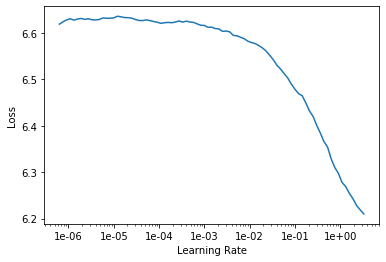

In [21]:
learn = Learner(data, model, loss_func =nn.CrossEntropyLoss(), metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(10, max_lr = 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.139177,5.073565,0.044807,00:58
1,4.027275,4.088598,0.090656,00:59
2,3.574731,4.473158,0.101424,00:59
3,3.288008,3.358284,0.200764,00:59
4,3.057026,2.932828,0.267801,00:59
5,2.750815,2.766217,0.304620,00:59
6,2.526336,2.358779,0.404654,00:58
7,2.254963,2.162658,0.445641,00:59
8,2.010250,1.996290,0.481764,00:58
9,1.884258,1.957008,0.493574,01:00


# Darknet53

In [10]:
def conv(ni,nf,ks=3,stride=1): return nn.Conv2d(ni,nf,kernel_size=ks,stride=stride, padding=ks//2)

In [11]:
def darknet_conv_layer(ni,nf, ks=3, stride=1):
    return nn.Sequential(conv(ni,nf,ks=ks, stride=stride),
                        nn.BatchNorm2d(nf),
                        nn.LeakyReLU(negative_slope=0.1))

In [12]:
class darkent_ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = darknet_conv_layer(nf,nf//2,ks=1)
        self.conv2 = darknet_conv_layer(nf//2,nf,ks=3)
    def forward(self,x):
        return x+ self.conv2(self.conv1(x))

In [62]:
def darknet_conv_block(ni,nf):
    return nn.Sequential(darknet_conv_layer(ni,nf), darkent_ResBlock(nf))

In [63]:
model = nn.Sequential(
    darknet_conv_block(3,32),
    darknet_conv_block(32,64),
    darknet_conv_block(64,128),
    darknet_conv_block(128,64),
    darknet_conv_block(64,data.c),
    Flatten()
    )

In [64]:
learn = Learner(data, model, loss_func =nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(10, max_lr = 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.809034,5.253026,0.007989,02:13
1,5.241345,5.209623,0.007294,02:15
2,5.201990,5.205970,0.007642,02:14
3,5.195568,5.419900,0.007642,02:14
4,5.191395,5.183039,0.010073,02:14
5,5.189970,5.177526,0.012157,02:14
6,5.182010,5.196301,0.009031,02:15
7,5.178741,5.179193,0.011115,02:13
8,5.174839,5.172311,0.012157,02:13
9,5.177893,5.171547,0.011462,02:13


In [13]:
class Darknet(nn.Module):
    def make_group_layers(self, chin, num_blocks,stride=1):
        return [darknet_conv_layer(chin, chin*2, stride=stride)]+[darkent_ResBlock(chin*2) for i in range(num_blocks)]
        
    def __init__(self, blocks, num_classes, nf=32):
        super().__init__()
        layers = [darknet_conv_layer(3,nf, ks=2, stride=1)]
        for i,nb in enumerate(blocks):
            layers+= self.make_group_layers(nf, nb,stride =2-(i==1))
            nf*=2

        layers+=[nn.AdaptiveAvgPool2d(1),Flatten(), nn.Linear(nf,num_classes)]
        self.layers= nn.Sequential(*layers)
    
    def forward(self,x):
        return self.layers(x)

In [107]:
model = Darknet([1,2,8,8,4], num_classes=data.c, nf=32)

learn = Learner(data, Darknet([1,2,8,8,4], data.c), loss_func =nn.CrossEntropyLoss(), metrics=accuracy)
learn.summary()

Darknet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 65, 65]         416        True      
______________________________________________________________________
BatchNorm2d          [32, 65, 65]         64         True      
______________________________________________________________________
LeakyReLU            [32, 65, 65]         0          False     
______________________________________________________________________
Conv2d               [64, 33, 33]         18,496     True      
______________________________________________________________________
BatchNorm2d          [64, 33, 33]         128        True      
______________________________________________________________________
LeakyReLU            [64, 33, 33]         0          False     
______________________________________________________________________
Conv2d               [32, 33, 33]         2,080      True      
______________________________________________________

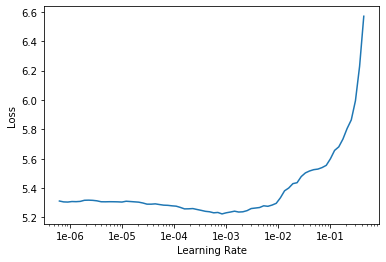

In [109]:
learn.lr_find()
learn.recorder.plot()

In [110]:
learn.fit_one_cycle(10, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,4.969404,4.747329,0.048281,02:30
1,3.878295,3.880172,0.106287,02:29
2,3.212789,3.252526,0.184092,02:28
3,2.634941,2.920052,0.267454,02:26
4,2.146676,2.120036,0.425148,02:27
5,1.693644,1.827183,0.498437,02:27
6,1.366115,1.472424,0.603334,02:26
7,1.084770,1.236489,0.662035,02:27
8,0.890082,1.100910,0.696770,02:30
9,0.811438,1.089218,0.705801,02:29


# Wide ResNet
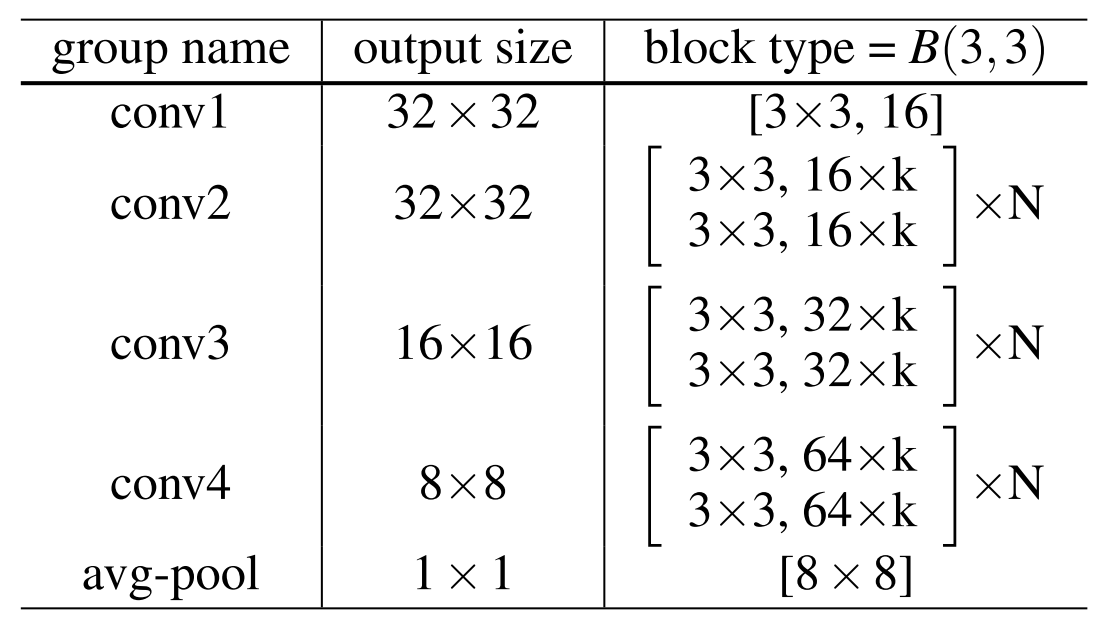

In [6]:
def conv(ni,nf,ks=3,stride=1): return nn.Conv2d(ni,nf,kernel_size=ks,stride=stride, padding=1)

In [7]:
def wide_conv_layer(ni,nf, ks=3, stride=1):
    return nn.Sequential(conv(ni,nf,ks=ks, stride=stride),
                        nn.BatchNorm2d(nf),
                        nn.ReLU())

In [8]:
class wideresnet_ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = wide_conv_layer(nf,nf,ks=3, stride=1)
        self.conv2 = wide_conv_layer(nf,nf,ks=3, stride=1)
    def forward(self,x):
        return x+ self.conv2(self.conv1(x))

In [9]:
class wideresnet(nn.Module):
    def make_group_layers(self, chin, chout, N,stride=1):
        return [wide_conv_layer(chin, chout, stride=stride)] +[wideresnet_ResBlock(chout) for i in range(N)]
        
    def __init__(self, n_grps, k, N,n_class, nf=16):
        super().__init__()
        layers = [conv(3,nf, ks=3,stride=1)]
        width = [nf]
        for n in range(n_grps):
            width+= [nf *(2**n)*k]
        for n in range(n_grps):
            layers += self.make_group_layers(width[n], width[n+1], N,stride = (1 if n==0 else 2))

        layers+=[nn.AdaptiveAvgPool2d(1),Flatten(), nn.Linear(width[-1],n_class)]
        self.layers= nn.Sequential(*layers)
    
    def forward(self,x):
        return self.layers(x)

In [11]:
model = wideresnet(n_grps=3, N=4, k=5, n_class=data.c)

In [12]:
learn = Learner(data, model, loss_func =nn.CrossEntropyLoss(), metrics=accuracy)

In [13]:
learn.summary()

wideresnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 64]         448        True      
______________________________________________________________________
Conv2d               [80, 64, 64]         11,600     True      
______________________________________________________________________
BatchNorm2d          [80, 64, 64]         160        True      
______________________________________________________________________
ReLU                 [80, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [80, 64, 64]         57,680     True      
______________________________________________________________________
BatchNorm2d          [80, 64, 64]         160        True      
______________________________________________________________________
ReLU                 [80, 64, 64]         0          False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


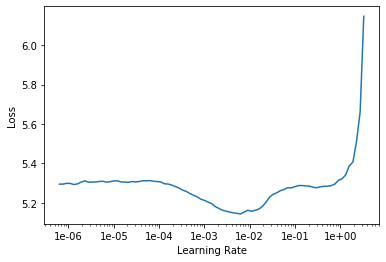

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10, max_lr=slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,4.977993,4.753379,0.058354,04:10
1,4.094347,3.930854,0.118097,02:56
2,3.546098,3.463130,0.179229,02:58
3,3.151598,3.092835,0.237235,03:00
4,2.760735,2.763648,0.299410,03:11
5,2.459427,2.648716,0.326850,02:57
6,2.184664,2.162669,0.443904,03:01
7,1.963990,1.964711,0.515109,03:06
8,1.870469,1.874338,0.547760,02:54
9,1.806214,1.840476,0.554707,02:54


# Fin